In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from os import listdir
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
variable_name = 'Civilian Population in Labor Force 16 Years and Over: Unemployed'
image_dir = '/data/Images/'

In [3]:
def import_raster(city_name, spatial_res, band_index):
    
    """Imports the raster stack using gdal
       Then convert a selected band into a numpy array
       Then plots the 1-band image
       
       Requires:
           The file path for the raster stack
           The index value of the desired raster band
           
       Outputs:
           An image of the i-th band of the raster stack"""
    
    file_path = (image_dir + '/' + city_name + '/' + city_name +
                 str(spatial_res) + '.tif')
    
    # Import
    raster_stack = gdal.Open(file_path)
    # Convert
    raster_array = raster_stack.GetRasterBand(band_index).ReadAsArray();
    
    # Store the array
    return(raster_array)

In [4]:
def import_all_for_city(city_name):
    
    
    # For 10 meter bands
    spatial_res = 10
    for i in range(1, 5):
        band_index = i
        ten_m = import_raster(city_name, spatial_res, band_index)
        ten_m = ten_m.reshape(1, ten_m.shape[0], ten_m.shape[1])
        if i == 1:
            ten_m_stack = ten_m
        else:
            ten_m_stack = np.concatenate((ten_m_stack, ten_m))
    
    
    # For 20 meter bands
    spatial_res = 20
    for i in range(1, 6):
        band_index = i
        twenty_m = import_raster(city_name, spatial_res, band_index)
        twenty_m = twenty_m.reshape(1, twenty_m.shape[0], twenty_m.shape[1])
        if i == 1:
            twenty_m_stack = twenty_m
        else:
            twenty_m_stack = np.concatenate((twenty_m_stack, twenty_m))
    
    
    # For 60 meter bands
    spatial_res = 60
    for i in range(1, 4):
        band_index = i
        sixty_m = import_raster(city_name, spatial_res, band_index)
        sixty_m = sixty_m.reshape(1, sixty_m.shape[0], sixty_m.shape[1])
        if i == 1:
            sixty_m_stack = sixty_m
        else:
            sixty_m_stack = np.concatenate((sixty_m_stack, sixty_m))
        
    return(ten_m_stack, twenty_m_stack, sixty_m_stack)

In [5]:
ten, twenty, sixty = import_all_for_city('Albany')

In [6]:
print(ten.shape)
print(twenty.shape)
print(sixty.shape)

(4, 498, 444)
(5, 249, 222)
(3, 83, 74)


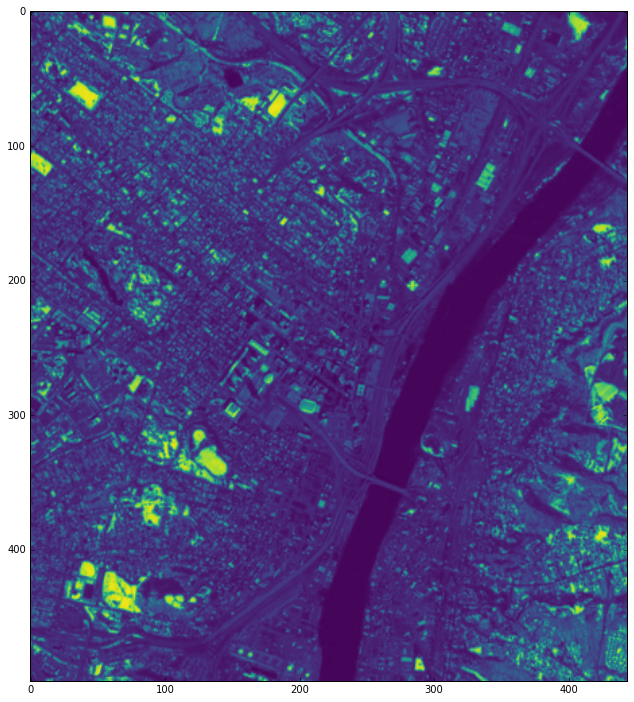

In [7]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 12)

plt.imshow(ten[0], cmap = 'viridis');

## Model

In [8]:
def make_array_ready(array):
    
    tensor = torch.from_numpy(array)
    variable = Variable(tensor).type(torch.FloatTensor)
    
    #midpoint1 = var
    
    return(variable)

In [9]:
def fix_dim(variable, res):
    
    variable = variable.unsqueeze(dim = 0)
    variable = variable.unsqueeze(dim = 0)
    
    midpoint1 = int(variable.size()[2] / 2)
    midpoint2 = int(variable.size()[3] / 2)
    
    if res == 10:
        variable = variable[:, :, (midpoint1 - 200):(midpoint1 + 200), (midpoint2 - 200):(midpoint2 + 200)]
        
    if res == 20: 
        variable = variable[:, :, (midpoint1 - 100):(midpoint1 + 100), (midpoint2 - 100):(midpoint2 + 100)]

    if res == 60: 
        variable = variable[:, :, (midpoint1 - 34):(midpoint1 + 34), (midpoint2 - 34):(midpoint2 + 34)]

        
    return(variable)

In [10]:
ten, twenty, sixty = [make_array_ready(array) for array in [ten, twenty, sixty]]

band1, band2, band3, band4 = [fix_dim(i, 10) for i in ten]
band5, band6, band7, band8, band9 = [fix_dim(i, 20) for i in twenty]
band10, band11, band12 = [fix_dim(i, 60) for i in sixty]

In [11]:
torch.manual_seed(1234)

class Ensemble(nn.Module):
    def __init__(self):
        super(Ensemble, self).__init__()
        
        self.band_1_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_2_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_3_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_4_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_5_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_6_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_7_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_8_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_9_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_10_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_11_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        self.band_12_cnn = nn.Sequential(nn.Conv2d(1, 2, kernel_size = 5, padding = 2),
                             nn.ReLU(),
                             nn.Conv2d(2, 4, kernel_size = 5, padding = 2),
                             nn.ReLU())
        
        self.band_1_fc = nn.Linear(4*400*400, 1)
        self.band_2_fc = nn.Linear(4*400*400, 1)
        self.band_3_fc = nn.Linear(4*400*400, 1)
        self.band_4_fc = nn.Linear(4*400*400, 1)
        self.band_5_fc = nn.Linear(4*200*200, 1)
        self.band_6_fc = nn.Linear(4*200*200, 1)
        self.band_7_fc = nn.Linear(4*200*200, 1)
        self.band_8_fc = nn.Linear(4*200*200, 1)
        self.band_9_fc = nn.Linear(4*200*200, 1)
        self.band_10_fc = nn.Linear(4*68*68, 1)
        self.band_11_fc = nn.Linear(4*68*68, 1)
        self.band_12_fc = nn.Linear(4*68*68, 1)
        
        self.ensemble_fc = nn.Linear(12, 1)
        
    def forward(self, band1, band2, band3, band4,
                band5, band6, band7, band8,
                band9, band10, band11, band12):
        
        band1_cnn_output = self.band_1_cnn(band1).view(-1)
        band2_cnn_output = self.band_2_cnn(band2).view(-1)
        band3_cnn_output = self.band_3_cnn(band3).view(-1)
        band4_cnn_output = self.band_4_cnn(band4).view(-1)
        band5_cnn_output = self.band_5_cnn(band5).view(-1)
        band6_cnn_output = self.band_6_cnn(band6).view(-1)
        band7_cnn_output = self.band_7_cnn(band7).view(-1)
        band8_cnn_output = self.band_8_cnn(band8).view(-1)
        band9_cnn_output = self.band_9_cnn(band9).view(-1)
        band10_cnn_output = self.band_10_cnn(band10).view(-1)
        band11_cnn_output = self.band_11_cnn(band11).view(-1)
        band12_cnn_output = self.band_12_cnn(band12).view(-1)
        
        band1_fc_output = self.band_1_fc(band1_cnn_output)
        band2_fc_output = self.band_2_fc(band2_cnn_output)
        band3_fc_output = self.band_3_fc(band3_cnn_output)
        band4_fc_output = self.band_4_fc(band4_cnn_output)
        band5_fc_output = self.band_5_fc(band5_cnn_output)
        band6_fc_output = self.band_6_fc(band6_cnn_output)
        band7_fc_output = self.band_7_fc(band7_cnn_output)
        band8_fc_output = self.band_8_fc(band8_cnn_output)
        band9_fc_output = self.band_9_fc(band9_cnn_output)
        band10_fc_output = self.band_10_fc(band10_cnn_output)
        band11_fc_output = self.band_11_fc(band11_cnn_output)
        band12_fc_output = self.band_12_fc(band12_cnn_output)
        
        ensemble_input = torch.cat((band1_fc_output,
                                    band2_fc_output,
                                    band3_fc_output,
                                    band4_fc_output,
                                    band5_fc_output,
                                    band6_fc_output,
                                    band7_fc_output,
                                    band8_fc_output,
                                    band9_fc_output,
                                    band10_fc_output,
                                    band11_fc_output,
                                    band12_fc_output))
        
        final_output = self.ensemble_fc(ensemble_input)
        
        return(final_output)
        
model = Ensemble()

loss_function = loss_fn = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.Adam(model.parameters(), weight_decay = 0.1)

<br><br><br>

In [12]:
cities = listdir(image_dir)
cities = np.asarray(cities)
cities

array(['Lansing_MI', 'Albany', 'DesMoines_IA', 'Phoenix_AZ', 'Raleigh',
       'Providence', 'CarsonCity', 'Bismarck', 'Harrisburg', 'Boise_ID',
       'Pierre', 'Wash_DC', 'Sacramento_CA', 'Juneau_AK', 'Charleston',
       'Indianapolis_IN', 'SaintPaul_MN', 'Jackson_MS', 'Trenton',
       'Hartford_CT', 'Concord', 'SaltLakeCity', 'Columbia', 'Augusta_ME',
       'Frankfort_KY', 'Nashville', 'Montgomery_AL', 'Columbus',
       'Baltimore_MD', 'Atlanta_GA', 'Denver', 'Topeka_KS', 'Helena',
       'Cheyenne', 'SanteFe', 'Springfield_IL', 'Madison', 'BatonRouge_LA',
       'Richmond', 'Dover_DE', 'Boston_MA', 'OklahomaCity', 'Salem',
       'LittleRock_AR', 'Olympia', 'Tallahassee_FL', 'Austin', 'Lincoln',
       'JeffersonCity_MO', 'Honolulu_HI'], 
      dtype='<U16')

In [13]:
cities_for_df = ['Montgomery_AL', 'Juneau_AK', 'Phoenix_AZ', 'LittleRock_AR',
                 'Sacramento_CA', 'Denver', 'Hartford_CT', 'Dover_DE',
                 'Wash_DC', 'Tallahassee_FL', 'Atlanta_GA', 'Honolulu_HI',
                 'Boise_ID', 'Springfield_IL', 'Indianapolis_IN', 'DesMoines_IA',
                 'Topeka_KS', 'Frankfort_KY', 'BatonRouge_LA', 'Augusta_ME',
                 'Baltimore_MD', 'Boston_MA', 'Lansing_MI', 'SaintPaul_MN', 'Jackson_MS',
                 'JeffersonCity_MO', 'Helena', 'Lincoln', 'CarsonCity',
                 'Concord', 'Trenton', 'SanteFe', 'Albany', 'Raleigh',
                 'Bismarck', 'Columbus', 'OklahomaCity', 'Salem',
                 'Harrisburg', 'Providence', 'Columbia', 'Pierre',
                 'Nashville', 'Austin', 'SaltLakeCity', 'Richmond',
                 'Olympia', 'Charleston', 'Madison', 'Cheyenne']

In [14]:
socy_df = pd.read_csv('Final_SES_CSV.csv')
socy_df = socy_df.iloc[1:]
socy_df['Qualifying Name'] = cities_for_df

socy_df = socy_df[['Qualifying Name', variable_name]]
socy_df = socy_df.dropna()
socy_df = socy_df.reset_index(drop = True)
socy_df

,Qualifying Name,Civilian Population in Labor Force 16 Years and Over: Unemployed
0,Montgomery_AL,8555
1,Juneau_AK,929
2,Phoenix_AZ,59928
3,LittleRock_AR,6517
4,Sacramento_CA,25148
5,Denver,20514
6,Hartford_CT,10465
7,Dover_DE,1399
8,Wash_DC,33326
9,Tallahassee_FL,11678


In [15]:
new_cities = []

print("Cities excluded from this particular analysis include...\n")
for city in cities:
    if (city in socy_df['Qualifying Name'].values.tolist()):
        new_cities.append(city)
    else:
        print(city)

Cities excluded from this particular analysis include...



In [16]:
train_cities, test_cities = train_test_split(new_cities, test_size = 0.2, random_state = 1234)

In [17]:
test_cities

['BatonRouge_LA',
 'Tallahassee_FL',
 'CarsonCity',
 'Olympia',
 'Juneau_AK',
 'Madison',
 'Harrisburg',
 'Atlanta_GA',
 'Raleigh',
 'Honolulu_HI']

In [18]:
np.random.seed(1234)

def train_model(model):
    
    # Set up
    random_index = np.random.choice(len(train_cities))
    random_city = new_cities[random_index]
    
    ten, twenty, sixty = import_all_for_city(random_city)
    
    ten, twenty, sixty = [make_array_ready(array) for array in [ten, twenty, sixty]]
    
    band1, band2, band3, band4 = [fix_dim(i, 10) for i in ten]
    band5, band6, band7, band8, band9 = [fix_dim(i, 20) for i in twenty]
    band10, band11, band12 = [fix_dim(i, 60) for i in sixty]
    
    stochastic_row = socy_df[socy_df['Qualifying Name'] == random_city]
    Y = (stochastic_row[variable_name].values)
    Y = Y.astype(float)
    Y = Variable(torch.from_numpy(Y)).type(torch.FloatTensor)
    
    # Training
    model.zero_grad()
    y_pred = model(band1, band2, band3, band4,
                   band5, band6, band7, band8,
                   band9, band10, band11, band12)
    loss = loss_function(y_pred, Y)
    loss.backward()
    optimizer.step()
    return(loss)

In [19]:
loss_list = []
for i in range(400):
    loss_list.append(train_model(model).data.item())

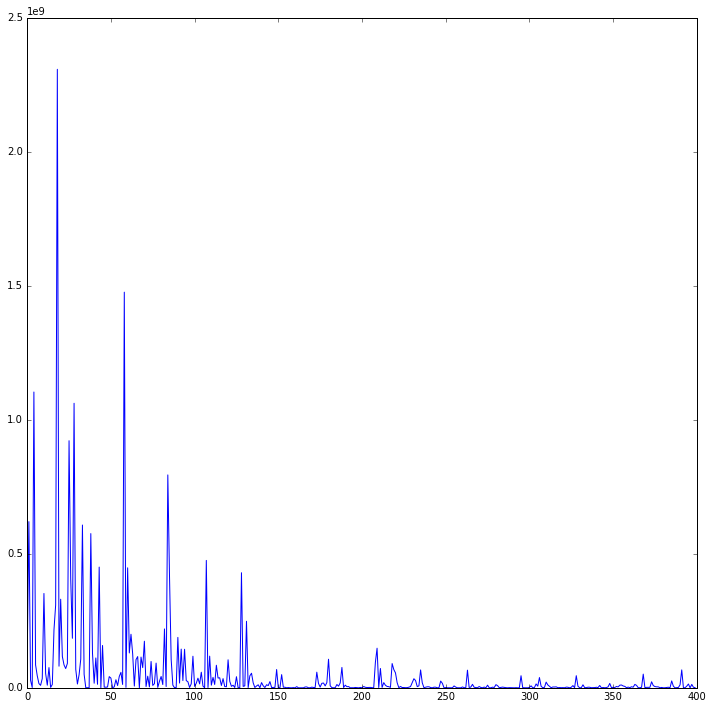

In [20]:
plt.plot(loss_list);

In [21]:
for i in model.ensemble_fc.parameters():
    print(i)

Parameter containing:
tensor([[ 0.2709,  0.0821, -0.1153,  0.0362,  0.2265, -0.0429,  0.2415,
         -0.0859,  0.1034, -0.1757,  0.0555,  0.1266]])
Parameter containing:
tensor(1.00000e-02 *
       [ 2.1697])


In [22]:
pred_list = []
train_indicator_list = []

for city in socy_df['Qualifying Name'].values:
    train_indicator_list.append(city in train_cities)
    
    ten, twenty, sixty = import_all_for_city(city)
    
    ten, twenty, sixty = [make_array_ready(array) for array in [ten, twenty, sixty]]
    
    band1, band2, band3, band4 = [fix_dim(i, 10) for i in ten]
    band5, band6, band7, band8, band9 = [fix_dim(i, 20) for i in twenty]
    band10, band11, band12 = [fix_dim(i, 60) for i in sixty]
    
    y_pred = model(band1, band2, band3, band4,
                   band5, band6, band7, band8,
                   band9, band10, band11, band12)
    pred_list.append(y_pred.data.numpy()[0])

In [23]:
socy_df['Predicted'] = pred_list
socy_df['Train_Indicator'] = train_indicator_list
socy_df

,Qualifying Name,Civilian Population in Labor Force 16 Years and Over: Unemployed,Predicted,Train_Indicator
0,Montgomery_AL,8555,9392.775391,True
1,Juneau_AK,929,1669.536499,False
2,Phoenix_AZ,59928,57596.597656,True
3,LittleRock_AR,6517,11292.717773,True
4,Sacramento_CA,25148,27113.392578,True
5,Denver,20514,26477.326172,True
6,Hartford_CT,10465,12365.539062,True
7,Dover_DE,1399,1582.359741,True
8,Wash_DC,33326,38697.957031,True
9,Tallahassee_FL,11678,12541.517578,False


In [24]:
train_df = socy_df.copy()
train_df = train_df[train_df['Train_Indicator'] == True]

test_df = socy_df.copy()
test_df = test_df[test_df['Train_Indicator'] == False]

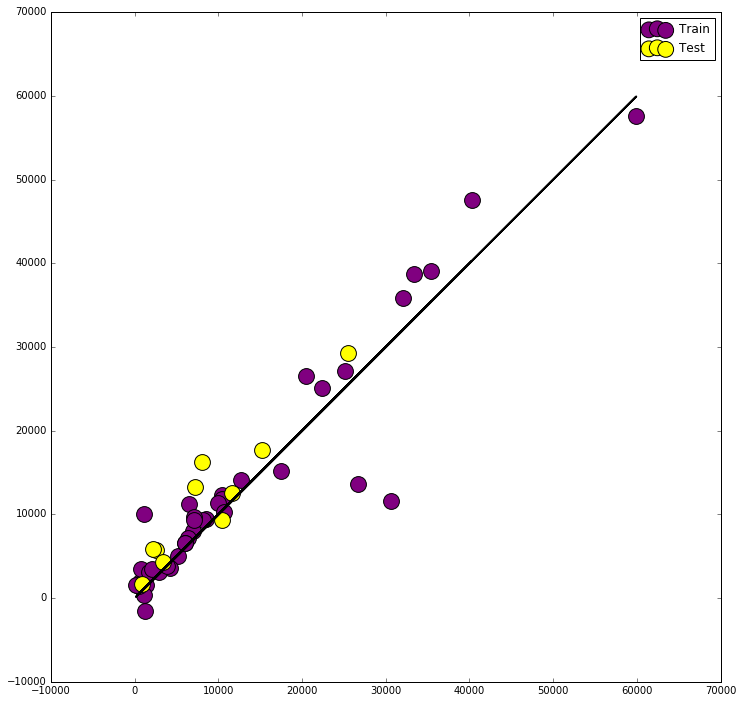

In [25]:
plt.scatter(train_df[variable_name],
            train_df['Predicted'], s = 250,
            c = 'purple', label = 'Train')

plt.scatter(test_df[variable_name],
            test_df['Predicted'], s = 250,
            c = 'yellow', label = 'Test')

plt.legend()

plt.plot(socy_df[variable_name].values.tolist(),
         socy_df[variable_name].values.tolist(),
         c = 'black', lw = 2);

In [26]:
r2_score(train_df[variable_name].values.astype(float).tolist(),
         train_df['Predicted'].values.astype(float).tolist())

0.8805257569062902

In [27]:
r2_score(test_df[variable_name].values.astype(float).tolist(),
         test_df['Predicted'].values.astype(float).tolist())

0.70197546599696037